### Importações das bibliotecas


In [1]:
import datetime
import numpy as np

# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# divisão em treino e teste, escalona e faz encoding de variáveis categóricas
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE

# métricas de performance de modelos
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# importando randomforestclassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna
import optuna.logging
# Definindo que apenas os avisos serão exibidos, para evitar spam nos outputs.
optuna.logging.set_verbosity(optuna.logging.WARNING)

g:\Program Files (x86)\Python 3 11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importando a base de dados

In [2]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

In [3]:
# Treina o modelo, exibe precisão/recall, matriz de confusão, feature_importance
# retorna o modelo treinado, X_test, y_test, y_pred
def treinar_modelo(modelo, X: pd.DataFrame, y: pd.Series, metrics_report: bool=False, feature_importance_report: bool=False) -> Pipeline:      
    # Criando o StratifiedKFold
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']

    # Definindo um pipeline com StandardScaler e LogisticRegression
    pipeline = Pipeline([
        ('encoder', TargetEncoder(cols=cat_features)),
        ('scaler', StandardScaler()),
        ('modelo', modelo)
    ])

    # Definindo as métricas
    scoring = [
        'precision_weighted',
        'recall_weighted',
        'f1_weighted'
               ]
        
    # Calculando as métricas usando cross_validate
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        
    # treinando o modelo para obter a matriz de confusao
    train_index, test_index = next(skf.split(X,y))
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # treinamos a pipeline
    pipeline.fit(X_train, y_train)
    
    # obtemos os resultados para aplicar nas funções das métricas
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    
    # pr_auc: Precision-Recall Area Under the Curve
    precisao, revocacao, limiares = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(revocacao, precisao)
    
            
    # exibe métricas e matriz de confusão
    if metrics_report:
            # Exibindo as métricas
            print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.2%}")
            print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.2%}")
            print(f"Média do F1 Score (Weighted): {scores['test_f1_weighted'].mean():.2%}")
            print(f'Precisão x Revocação, Área abaixo da Curva: ({pr_auc:.2%}) -> {pr_auc:.16f}')
        
            # plotando a matriz de confusão da cross_validate
            matriz_confusao = confusion_matrix(y_test, y_pred)
            sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Greens')

            # Configurações do gráfico
            plt.title('Matriz de confusão')
            plt.xlabel('Valor Predito')
            plt.ylabel('Valor Real')
            plt.show();    

    if feature_importance_report:
        # Acessando a importância das features
        if hasattr(pipeline.named_steps['modelo'], 'feature_importances_'):
            feature_importances = pipeline.named_steps['modelo'].feature_importances_
            importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
            importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
            print(importances_df)
            
    return pipeline, X_test, y_test, y_pred

In [16]:
# Relatório de Recursive Feature Elimination
def rfe_report(modelo, min_range: int=13, max_range: int=23) -> list:
    # Definir o StratifiedKFold com 2 folds
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=47)
    
    # Loop sobre os folds do StratifiedKFold para obter os splits estratificados
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    # Definimos quais são as features categóricas
    cat_features = ['posse_residencia_cliente', 'finalidade_emprestimo', 'nota_emprestimo']
    
    # Instanciamos o Encoder
    encoder = TargetEncoder(min_samples_leaf=450, smoothing=11.5, cols=cat_features)
    
    # Ajustamos o encoder apenas ao conjunto de treinamento
    encoder.fit(X_train[cat_features], y_train)
    
    # Aplicamos a transformação tanto no treinamento quanto no teste
    X_train.loc[:, cat_features] = encoder.transform(X_train[cat_features])
    X_test.loc[:, cat_features] = encoder.transform(X_test[cat_features])
    
    # instanciamos o RFE
    selector = RFE(estimator=modelo)
    
    # Identificar as features selecionadas
    X_train_df = pd.DataFrame(X_train)
    
    # Instanciando variáveis controle:
    melhor_pr_auc = 0
    
    for qtd_features in range(min_range, max_range, 2):
        # definimos o número de features que devem permanecer
        selector.n_features_to_select = qtd_features

        # Executar RFE no fold de treino
        selector.fit(X_train, y_train)
        features_selecionadas = selector.support_

        # Filtrar as features selecionadas
        X_train_selecionado = X_train.loc[:, features_selecionadas]
        X_test_selecionado = X_test.loc[:, features_selecionadas]

        # Treinar o modelo com as features selecionadas
        modelo.fit(X_train_selecionado, y_train)

        # Prever probabilidades no fold de teste
        y_pred_proba = modelo.predict_proba(X_test_selecionado)[:, 1]

        # Calcular a curva Precision-Recall e AUC
        precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
        metrica_pr_auc = auc(revocacao, precisao)
        nome_features_selecionadas = [X_train_df.columns[i] for i, item in enumerate(features_selecionadas) if item]  
        
        # Comparar e atualizar o melhor resultado encontrado
        if metrica_pr_auc > melhor_pr_auc:         
            melhor_modelo_n_features = qtd_features
            melhores_features = nome_features_selecionadas.copy()
            melhor_pr_auc = metrica_pr_auc
    
        # exibe as informações do RFE atual
        print('----------------------------------------------')
        print(f'RFE {qtd_features} features - [INFO] Precision Recall AUC: ', metrica_pr_auc)
    # exibe as informações do melhor RFE
    print('----------------------------------------------')
    print(f'MELHOR "X_train" com {melhor_modelo_n_features} features:')
    print('[END] Precision Recall AUC: ', melhor_pr_auc)
    print("[END] Features selecionadas: ", melhores_features)
    
    # retorna as features que retornaram a melhor métrica
    return melhores_features

# Modelagem
### Feature Engineering
Utilizaremos:
- Médias e desvios-padrão de features; e
- ratios: divisão de uma feature por outra

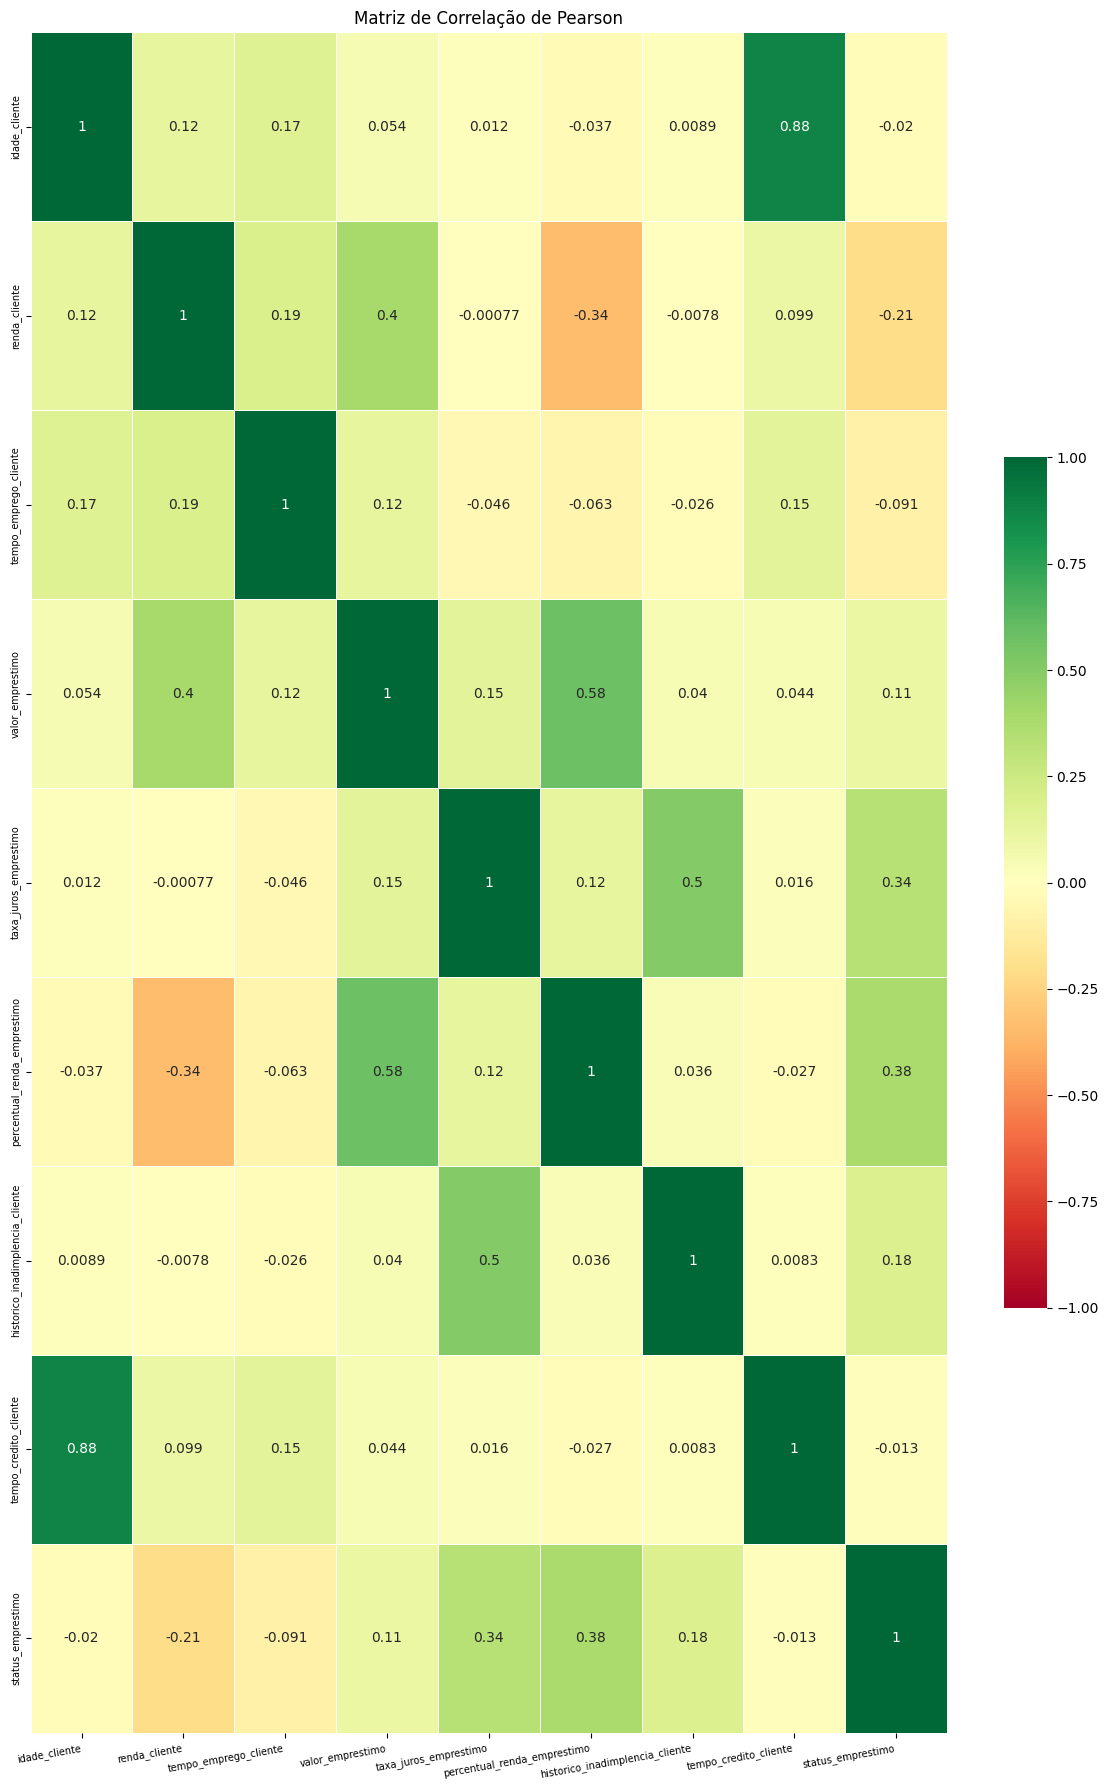

In [11]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz de correlação de Pearson
corr_matrix = df[numeric_cols].corr()

sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma correlação positiva moderada entre as variáveis:
- **`idade_cliente`** e **`tempo_credito_cliente`**; e
- **`taxa_juros_emprestimo`** e **`historico_inadimplencia_cliente`**

Com base nisso, criaremos as seguintes features:
 1. retorno_emprestimo = multiplicando (taxa_juros_emprestimo por valor_emprestimo) + valor_empréstimo;
 2. ratio_renda_emp = dividindo renda por emprestimo;
 3. ratio_emprego_credito = tempo_emprego_cliente dividido por tempo_credito_cliente, caso dividir por zero, resulta em zero;
 4. media_valemp_nota = média de valor_emprestimo para cada nota_emprestimo;
 5. media_valoremp_finalidade = média de valor_emprestimo para cada finalidade_emprestimo;
 6. std_valemp_residencia = desvio-padrão do valor_emprestimo por posse_residencia_cliente;
 7. media_renda_nota = média de renda_cliente para cada nota_emprestimo;
 8. media_renda_finalidade = média de renda_cliente para cada finalidade_emprestimo;
 9. std_renda_residencia = desvio-padrão do renda_cliente por posse_residencia_cliente;
10. ratio_emprego_renda = tempo_emprego_cliente dividido por renda_cliente
11. ratio_credito_renda = tempo_credito_cliente dividido por renda_cliente

In [5]:
# 1. 
df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)
# 2.
df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']
# 3. 
df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']
# 4.
df['media_valemp_nota'] = df.groupby(['nota_emprestimo'])['valor_emprestimo'].transform('mean')
# 5.
df['media_valemp_finalidade'] = df.groupby(['finalidade_emprestimo'])['valor_emprestimo'].transform('mean')
# 6.
df['std_valemp_residencia'] = df.groupby(['posse_residencia_cliente'])['valor_emprestimo'].transform('std')
# 7.
df['media_renda_nota'] = df.groupby(['nota_emprestimo'])['renda_cliente'].transform('mean')
# 8.
df['media_renda_finalidade'] = df.groupby(['finalidade_emprestimo'])['renda_cliente'].transform('mean')
# 9.
df['std_renda_residencia'] = df.groupby(['posse_residencia_cliente'])['renda_cliente'].transform('std')
# 10.
df['ratio_emprego_renda'] = df['tempo_emprego_cliente'] / df['renda_cliente']
# 11.
df['ratio_credito_renda'] = df['tempo_credito_cliente'] / df['renda_cliente']

In [6]:
# visualizando o dataset após implementação
df.head(15)

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,Alugada,23,Pessoal,D,35000,16.020000,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
1,21,9600,Própria,5,Educação,B,1000,11.140000,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,Hipoteca,1,Médico,C,5500,12.870000,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
3,23,65500,Alugada,4,Médico,C,35000,15.230000,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,Alugada,8,Médico,C,35000,14.270000,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,Própria,2,Empreendimento,A,2500,7.140000,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,Alugada,8,Educação,B,35000,12.420000,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
7,24,78956,Alugada,5,Médico,B,35000,11.110000,0.44,0,...,2.255886,1.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000063,0.000051
8,24,83000,Alugada,8,Pessoal,A,35000,8.900000,0.42,0,...,2.371429,4.000000,8521.565413,9586.847630,5814.229899,65154.163508,65187.707459,31495.813457,0.000096,0.000024
9,21,10000,Própria,6,Empreendimento,D,1600,14.740000,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300


Ficamos com 23 colunas no total, 11 a mais do que o dataset original.

### Avaliando a performance de modelos e respectivas Feature Importances

In [7]:
# separamos a variável dependente das independentes
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

Instanciamos a variável target e as variáveis independentes.

In [8]:
# definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Como a Classe 1 é rara, o modelo Random Forest precisa que seja instanciado a proporção inversa de cada classe, definindo o peso de cada uma.
- Classe 0 -> Peso: 0.6406821745948772
- Classe 1  -> Peso: 2.2770552717138877

In [21]:
# instanciando o modelo random forest com 30 n_estimators, entropia como critério e pesos das classes inversamente proporcionais
randomforestclassifier = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight=pesos, random_state=47)
# treinando o random forest
rf_treinado, _, _, _  = treinar_modelo(randomforestclassifier, X, y, True, True)

: 

Média da Precisão (Weighted): 93.80%
Média da Revocação (Weighted): 93.53%
Média do F1 Score (Weighted): 93.16%
Precisão x Revocação, Área abaixo da Curva: (90.81%) -> 0.9081230182607759


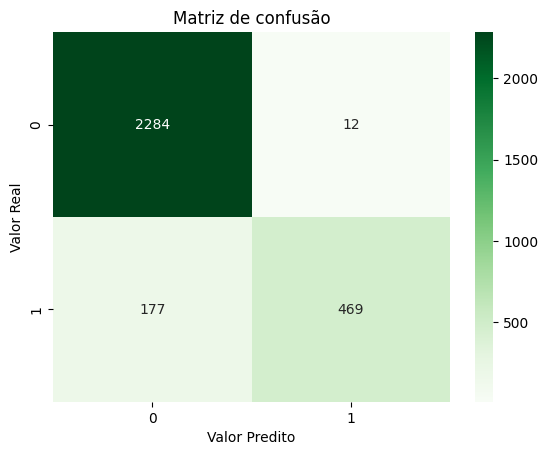

                            Feature  Importance
0                   ratio_renda_emp    0.243214
1                   nota_emprestimo    0.234856
2          posse_residencia_cliente    0.145219
3             tempo_emprego_cliente    0.080451
4             finalidade_emprestimo    0.068420
5                     renda_cliente    0.047948
6       percentual_renda_emprestimo    0.036799
7           media_valemp_finalidade    0.025053
8             taxa_juros_emprestimo    0.020729
9                     idade_cliente    0.019063
10            std_valemp_residencia    0.015410
11              ratio_emprego_renda    0.009339
12               retorno_emprestimo    0.008717
13            ratio_emprego_credito    0.008480
14              ratio_credito_renda    0.008412
15                 valor_emprestimo    0.006890
16            tempo_credito_cliente    0.005155
17                media_valemp_nota    0.004407
18                 media_renda_nota    0.004263
19  historico_inadimplencia_cliente    0

In [9]:
# instanciando o XGBClassifier
xgbclassifier = XGBClassifier(n_estimators=30, random_state=47)
# treinando o xgboost
xgboost_treinado, _, _, _  = treinar_modelo(xgbclassifier, X, y, True, True)

Média da Precisão (Weighted): 92.44%
Média da Revocação (Weighted): 92.22%
Média do F1 Score (Weighted): 91.73%
Precisão x Revocação, Área abaixo da Curva: (86.59%) -> 0.8659281184304057


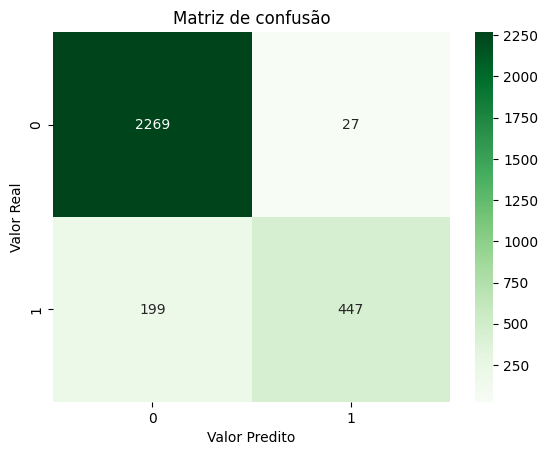

                            Feature  Importance
0                   ratio_renda_emp    0.326003
1                 media_valemp_nota    0.143346
2                   nota_emprestimo    0.125471
3                     renda_cliente    0.098135
4          posse_residencia_cliente    0.096833
5             finalidade_emprestimo    0.065812
6              std_renda_residencia    0.051447
7             std_valemp_residencia    0.035327
8             tempo_emprego_cliente    0.029592
9             taxa_juros_emprestimo    0.010836
10           media_renda_finalidade    0.006274
11      percentual_renda_emprestimo    0.005848
12          media_valemp_finalidade    0.004043
13                 media_renda_nota    0.001033
14                    idade_cliente    0.000000
15              ratio_emprego_renda    0.000000
16               retorno_emprestimo    0.000000
17            ratio_emprego_credito    0.000000
18            tempo_credito_cliente    0.000000
19  historico_inadimplencia_cliente    0

In [ ]:
gradientboostingclassifier = GradientBoostingClassifier(n_estimators=30, random_state=47)

gradientboost_treinado, _, _, _  = treinar_modelo(gradientboostingclassifier, X, y, True, True)

### Análise dos modelos e respectivas Features Importances
Para evitar overfitting e capturar ruídos dos dados, preferimos verificar a importância das features em cada modelo e tratar as piores posteriormente. Os modelos foram treinados com 10 folds no StratifiedKFold (SKF) em razão do desbalanceamento de classes, situação em que o SKF lida bem na distribuição de folds em treino e teste estratificando-os.
- Random Forest Classifier:
    - Média da Precisão (Weighted): 93.77%
    - Média da Revocação (Weighted): 93.43%
    - Média do F1 Score (Weighted): 93.03%
    - Precisão x Revocação, Área abaixo da Curva: 89.09%
    - Top 5 Feature Importance:
        - ratio_renda_emp;
        - percentual_renda_emprestimo;
        - renda_cliente;
        - taxa_juros_emprestimo;
        - nota_emprestimo;
    - Nenhuma feature sem importância para o modelo, sendo a menor **`historico_inadimplencia_cliente`** com 0.008585.
- XGBoost Classifier:
    - Média da Precisão (Weighted): 93.86%
    - Média da Revocação (Weighted): 93.60%
    - Média do F1 Score (Weighted): 93.24%
    - Precisão x Revocação, Área abaixo da Curva: 90.80%
    - Top 5 Feature Importance:
        - nota_emprestimo
        - ratio_renda_emp
        - posse_residencia_cliente
        - tempo_emprego_cliente
        - finalidade_emprestimo
        - std_valemp_residencia
    - 1 feature sem importância para o modelo, sendo ela **`std_renda_residencia`**.
- Gradient Boosting Classifier:
    - Média da Precisão (Weighted): 92.44%
    - Média da Revocação (Weighted): 92.22%
    - Média do F1 Score (Weighted): 91.73%
    - Precisão x Revocação, Área abaixo da Curva: 86.59%
    - Top 5 Feature Importance:
        - ratio_renda_emp
        - media_valemp_nota
        - nota_emprestimo
        - renda_cliente
        - posse_residencia_cliente
    - 8 features sem importância para o modelo, sendo 4 delas do DataFrame original.

O modelo que se saiu melhor em termos de minimizar os falsos positivos foi o Random Forest Classifier, contudo, desejamos diminuir o número de clientes inadimplentes que o modelo erra (falsos negativos). Logo o XGBoost Classifier obteve resultados melhores com um custo baixo de falsos positivos.

 ### Feature Selection
- RFE (Recursive Feature Elimination)
    - Testamos manualmente a quantidade de features cuja métrica utilizada foi a área abaixo da curva entre precisão e revocação (pr_auc).

In [ ]:
_ = rfe_report(randomforestclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8744478131004862
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8768031996312853
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8782180810695837
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8793833001195405
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8774793442258879
----------------------------------------------
MELHOR "X_train" com 19 features:
[END] Precision Recall AUC:  0.8793833001195405
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito

No RandomForestClassifier obtemos o melhor resultado com 19 features e pr_auc de: 0.8793833001195405

In [ ]:
features_RFE_randomforest = rfe_report(randomforestclassifier, 18, 21)

----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8906788253802397
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8907873990532975
----------------------------------------------
MELHOR "X_train" com 20 features:
[END] Precision Recall AUC:  0.8907873990532975
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'valor_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'tempo_credito_cliente', 'retorno_emprestimo', 'ratio_renda_emp', 'ratio_emprego_credito', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_renda_finalidade', 'std_renda_residencia', 'ratio_emprego_renda', 'ratio_credito_renda']


Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no Random Forest, descobrimos que com 20 features a área abaixo da curva é maior com 20 features e pr_auc de: 0.8807358888204707

In [17]:
features_RFE_xgboost = rfe_report(xgbclassifier)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:posse_residencia_cliente: object, finalidade_emprestimo: object, nota_emprestimo: object

No XGBClassifier obtemos o melhor resultado com 13 features e pr_auc de: 0.9034899193937984

In [13]:
_ = rfe_report(xgbclassifier, 14, 23)

C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_16068\989811792.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cat_features] = encoder.transform(X_train[cat_features])
C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_16068\989811792.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cat_features] = encoder.transform(X_test[cat_features])


----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8938019204177713
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8924420160755078
----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8904229613548036
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8927755492728
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8921073840893009
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8938019204177713
[END] Features selecionadas:  ['idade_cliente', 'renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade

Como o XGBoost Classifier foi o modelo que se saiu melhor nos resultados iniciais, resolvemos fazer mais uma busca nas quantidades de features restantes utilizando o RFE, porém, com a primeira busca o RFE exibiu a métrica mais alta e iremos mantê-la.

In [16]:
_ = rfe_report(gradientboostingclassifier)

----------------------------------------------
RFE 13 features - [INFO] Precision Recall AUC:  0.8584999171030162
----------------------------------------------
RFE 15 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 17 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 19 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 21 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
MELHOR "X_train" com 13 features:
[END] Precision Recall AUC:  0.8584999171030162
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp_residencia', 'media_r

No GradientBoostingClassifier obtemos o melhor resultado com 13 features e pr_auc de: 0.8584999171030162

In [20]:
features_RFE_gbc = rfe_report(gradientboostingclassifier, 14, 23)

----------------------------------------------
RFE 14 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 16 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 18 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 20 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
RFE 22 features - [INFO] Precision Recall AUC:  0.8582288363941273
----------------------------------------------
MELHOR "X_train" com 14 features:
[END] Precision Recall AUC:  0.8582288363941273
[END] Features selecionadas:  ['renda_cliente', 'posse_residencia_cliente', 'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo', 'taxa_juros_emprestimo', 'percentual_renda_emprestimo', 'retorno_emprestimo', 'ratio_renda_emp', 'media_valemp_nota', 'media_valemp_finalidade', 'std_valemp

Após verificarmos uma feature acima e abaixo da melhor métrica encontrada no GradientBoost, podemos confirmar que com 13 features a área abaixo da curva é maior.

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna


In [18]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 30, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # definir o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        criterion='entropy',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_randomforest], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [19]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo:", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo: 4:53:14.598743
Melhores hiperparâmetros:  {'n_estimators': 263, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 0.8533967890879526}


In [36]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # definir o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_xgboost], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [37]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no xgboost
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_xgboost = XGBClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

Tempo total de execução do estudo:  0:04:52.267914
Melhores hiperparâmetros:  {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.2890010316844866, 'gamma': 0.06322196656471735}


In [22]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # ['auto', 'sqrt', 'log2']
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, _ = treinar_modelo(modelo, X[features_RFE_gbc], y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, _ = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Report the score for pruning
    trial.report(metrica_pr_auc, step=0)
    
    # Prune trial if needed
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [23]:
# Registrar o tempo de início do estudo
start_time = datetime.datetime.now()

# executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_model_gradient_boost = GradientBoostingClassifier(**study.best_params)

# Registrar o tempo de término do estudo
end_time = datetime.datetime.now()

# Calcular a duração do estudo
duration = end_time - start_time
print("Tempo total de execução do estudo: ", duration)

print("Melhores hiperparâmetros: ", study.best_params)

g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  """Validation associated with set-wise metrics.
g:\Program Files (x86)\Python 3 11\Lib\site-packages\sklearn\metrics\_classific

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Guilherme Bibiano\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_13852\2606512428.py", line 6, in <module>
    study.optimize(objective, n_trials=30)
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\study.py", line 451, in optimize
    _optimize(
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 62, in _optimize
    _optimize_sequential(
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 159, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "g:\Program Files (x86)\Python 3 11\Lib\site-packages\optuna\study\_optimize.py", line 247, in _run_trial
    raise func_err
  File "

### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 93.88%
Média da Revocação (Weighted): 93.61%
Média do F1 Score (Weighted): 93.25%
Precisão x Revocação, Área abaixo da Curva: (90.58%) -> 0.9058087452412750


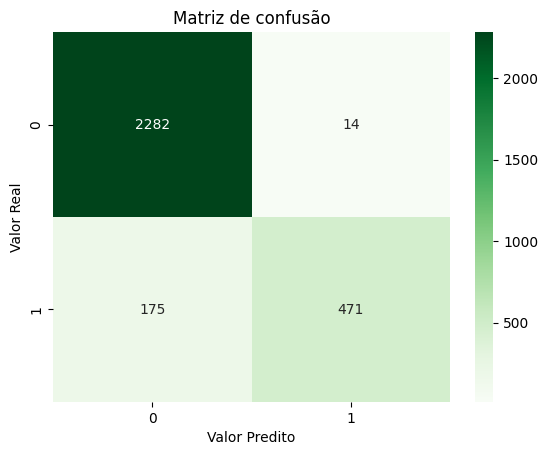

In [23]:
# treinando o random forest classifier
randomforestclassifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=254,
    max_depth=22,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=0.6469137671892833,
    class_weight=pesos, # peso das classes
    random_state=47
)

rf_treinado, _, _, _ = treinar_modelo(randomforestclassifier, X[features_RFE_randomforest], y, True)

Média da Precisão (Weighted): 93.82%
Média da Revocação (Weighted): 93.72%
Média do F1 Score (Weighted): 93.43%
Precisão x Revocação, Área abaixo da Curva: (92.13%) -> 0.9212761958539095


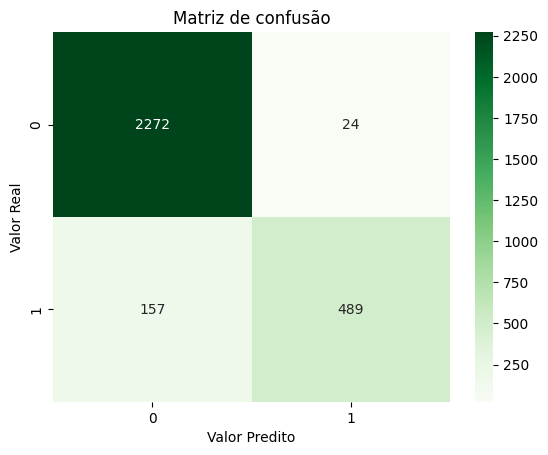

In [19]:
# treinando o xgboost classifier
xgbclassifier = XGBClassifier(
    n_estimators=272,
    max_depth=4,
    learning_rate=0.2890010316844866,
    gamma=0.06322196656471735,
    random_state=47
)

xgb_treinado, _, y_test, y_pred = treinar_modelo(xgbclassifier, X[features_RFE_xgboost], y, True)

Média da Precisão (Weighted): 93.76%
Média da Revocação (Weighted): 93.73%
Média do F1 Score (Weighted): 93.47%
Precisão x Revocação, Área abaixo da Curva: (90.96%) -> 0.9096130609034342


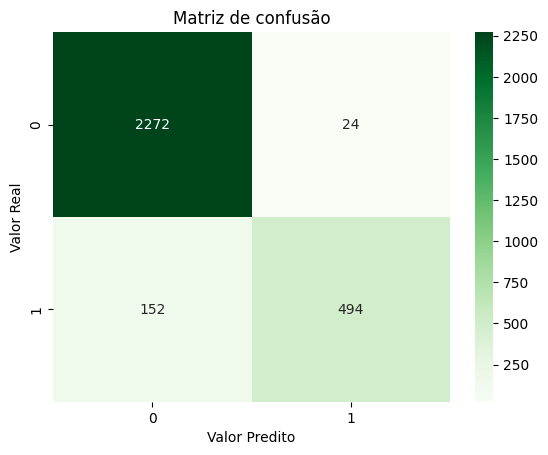

In [24]:
# treinando o gradient boosting classifier
gradientboostingclassifier = GradientBoostingClassifier(
    n_estimators=212,
    max_depth=13,
    learning_rate=0.5861968824622992,
    min_samples_split=18,
    min_samples_leaf=9,
    max_features=0.79471308745148,
    random_state=47
)

gbc_treinado, _, _, _ = treinar_modelo(gradientboostingclassifier, X[features_RFE_gbc], y, True)


### Modelo escolhido

Escolhemos o XGBoost Classifier pelas razões abaixo:
- Tempo de treinamento do modelo é rápido, resultando poucos segundos de atraso na resposta;
- Em produção não utiliza tanto processamento e memória; e
- O arquivo pickle do XGBoost Classifier é o mais leve.

Em um cenário **real**, escolheríamos o Gradient Boosting Classifier por ter se saído ligeiramente melhor na detecção de adimplentes e inadimplentes, porém, pelos motivos supramencionados e também para facilitar a implementação do modelo com treinamento em deploy iremos prosseguir com o XGBoost Classifier.

# Aplicação Prática de Negócio
Revisando a performance do modelo escolhido:
- **Média da Precisão (Weighted):** 93.82%
- **Média da Revocação (Weighted):** 93.72%
- **Média do F1 Score (Weighted):** 93.43%
- **Precisão x Revocação, Área abaixo da Curva:** 92.13%

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar 93.54% dos casos. Contudo, o modelo acertou apenas 93.66% dos casos em que ele previu que os clientes não pagariam.

**Inserindo em um contexto para visualizar a aplicabilidade deste modelo no negócio**
- Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, temos a proposta abaixo:

--------------------------------------------------------------------------------
Não conceder o valor de empréstimo solicitado pelos clientes inadimplentes.

--------------------------------------------------------------------------------

Para visualizar os efeitos desta proposta com esta solução utilizando machine learning devemos primeiro selecionar no banco de dados os clientes em que a previsão foi correta de clientes inadimplentes:

In [20]:
y_pred = pd.Series(y_pred)
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] == y_pred]
indices_1 = intersec[intersec == 1].index
X_test_1 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_1, :]
X_test_1

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
1,21,9600,0.071854,5,0.172761,0.162739,1000,11.14,0.10,0,...,9.600000,2.500000,9962.653301,9481.100478,6200.190887,65034.454516,63593.200957,41373.782824,0.000521,0.000208
2,25,9600,0.126933,1,0.270037,0.207946,5500,12.87,0.57,0,...,1.745455,0.333333,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000104,0.000313
9,21,10000,0.071854,6,0.148242,0.594864,1600,14.74,0.16,0,...,6.250000,2.000000,10824.456193,9568.263066,6200.190887,63193.286405,65236.276083,41373.782824,0.000600,0.000300
12,23,95000,0.317785,2,0.148242,0.100092,35000,7.90,0.37,0,...,2.714286,1.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000021,0.000021
15,23,120000,0.317785,0,0.172761,0.100092,35000,7.90,0.29,0,...,3.428571,0.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000000,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,25,36000,0.126933,0,0.270037,0.100092,5600,7.49,0.16,0,...,6.428571,0.000000,8521.565413,9244.618566,6770.406753,65154.163508,59818.228309,46037.084190,0.000000,0.000111
2909,23,48000,0.317785,7,0.286994,0.207946,3500,13.98,0.07,0,...,13.714286,1.750000,9221.676127,9567.238806,5814.229899,62525.863089,64680.251173,31495.813457,0.000146,0.000083
2912,23,48562,0.317785,4,0.148242,0.100092,3500,8.00,0.07,0,...,13.874857,2.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000082,0.000041
2921,21,30000,0.126933,5,0.262709,0.207946,13250,13.99,0.44,0,...,2.264151,1.666667,9221.676127,10318.158295,6770.406753,62525.863089,72813.853577,46037.084190,0.000167,0.000100


Podemos visualizar que pegamos um dos folds de teste com 490 clientes cuja previsão foram de inadimplentes.

Devemos agora verificar quanto de prejuízo evitamos, assim saberemos a eficácia da não concessão de empréstimo para estes clientes:

In [21]:
prejuizo_evitado = float((X_test_1['valor_emprestimo'].values).sum())
print(f'Evitaríamos o prejuízo de R$ {prejuizo_evitado:.2f}')

Evitaríamos o prejuízo de R$ 5021375.00


Evitamos perder R$ 5.021.375,00 (5 milhões).

Agora, podemos finalmente calcular o saldo bruto:

In [22]:
intersec = y_pred[y_test.reset_index().drop(columns='index', axis=1)['status_emprestimo'] == y_pred]
indices_2 = intersec[intersec == 0].index

# Selecionar as linhas correspondentes no dataset original df (supondo que df é o dataframe original)
X_test_2 = df.reset_index().drop(columns='index', axis=1).iloc[indices_2, :]
X_test_2

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
0,22,59000,0.317785,23,0.201360,0.594864,35000,16.02,0.59,1,...,1.685714,7.666667,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000390,0.000051
3,23,65500,0.317785,4,0.270037,0.207946,35000,15.23,0.53,0,...,1.871429,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000061,0.000031
4,24,54400,0.317785,8,0.270037,0.207946,35000,14.27,0.55,1,...,1.554286,2.000000,9221.676127,9244.618566,5814.229899,62525.863089,59818.228309,31495.813457,0.000147,0.000074
5,21,9900,0.071854,2,0.148242,0.100092,2500,7.14,0.25,0,...,3.960000,1.000000,8521.565413,9568.263066,6200.190887,65154.163508,65236.276083,41373.782824,0.000202,0.000202
6,26,77100,0.317785,8,0.172761,0.162739,35000,12.42,0.45,0,...,2.202857,2.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000104,0.000039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,23,63816,0.317785,4,0.172761,0.162739,3500,9.63,0.05,0,...,18.233143,1.333333,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000063,0.000047
2937,24,65000,0.317785,3,0.172761,0.100092,3500,7.74,0.05,0,...,18.571429,1.000000,8521.565413,9481.100478,5814.229899,65154.163508,63593.200957,31495.813457,0.000046,0.000046
2938,25,59000,0.317785,3,0.270037,0.594864,3500,15.65,0.06,0,...,16.857143,1.500000,10824.456193,9244.618566,5814.229899,63193.286405,59818.228309,31495.813457,0.000051,0.000034
2940,23,30000,0.126933,6,0.262709,0.100092,6725,6.99,0.22,0,...,4.460967,2.000000,8521.565413,10318.158295,6770.406753,65154.163508,72813.853577,46037.084190,0.000200,0.000100


Obtemos um dos folds de teste com 2269 clientes cuja previsão foi correta, classificando-os como adimplentes.

In [23]:
# multiplicamos o valor concedido por 1 + juros para obter o valor total que aquele cliente retornou
valor_concedido = float((X_test_2['valor_emprestimo'].values).sum())
print(f'Concedemos R$ {valor_concedido:.2f}')

Concedemos R$ 21853750.00


In [26]:
lucro_bruto = float((X_test_2['valor_emprestimo'].values*(X_test_2['taxa_juros_emprestimo'].values/100)).sum())
print(f'Obteríamos o lucro BRUTO de R$ {lucro_bruto:.2f}')

Obteríamos o lucro BRUTO de R$ 2617248.95


In [27]:
# retorno total
retorno_total = float(valor_concedido + lucro_bruto)
print(f'Retorno total das concessões de empréstimo: R$ {retorno_total:.2f}')

Retorno total das concessões de empréstimo: R$ 24470998.95


- Concedemos R$ 21.782.050,00 para os clientes (21.8 milhões)
- Nos retornou um **lucro BRUTO** de: R$ 2.617.248,95 (2.6 milhões)
- Possuímos um saldo até o momento de: R$ 24.470.998.95 (24.5 milhões)

Neste momento é importante verificar quanto deixaríamos de ganhar por prever erradamente os clientes que pagariam, classificando-os como inadimplentes:

In [28]:
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)['status_emprestimo'] != y_pred]
indices_3 = intersec[intersec == 1].index
X_test_3 = df.reset_index().drop(columns = 'index', axis = 1).iloc[indices_3, :]
X_test_3

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
157,26,200000,0.126933,4,0.172761,0.207946,15000,14.79,0.07,0,...,13.333333,1.333333,9221.676127,9481.100478,6770.406753,62525.863089,63593.200957,46037.084190,0.000020,0.000015
230,25,90000,0.317785,9,0.270037,0.162739,25000,10.99,0.28,0,...,3.600000,2.250000,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000100,0.000044
235,26,180000,0.071854,0,0.262709,0.100092,10000,8.00,0.06,0,...,18.000000,0.000000,8521.565413,10318.158295,6200.190887,65154.163508,72813.853577,41373.782824,0.000000,0.000022
361,23,287000,0.317785,3,0.172761,0.162739,24250,12.53,0.08,0,...,11.835052,1.000000,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000010,0.000010
495,22,75000,0.317785,2,0.172761,0.162739,21000,10.00,0.28,0,...,3.571429,0.666667,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000027,0.000040
557,24,51500,0.317785,6,0.148242,0.162739,20000,12.21,0.39,0,...,2.575000,1.500000,9962.653301,9568.263066,5814.229899,65034.454516,65236.276083,31495.813457,0.000117,0.000078
662,22,21600,0.126933,0,0.172761,0.100092,4025,5.42,0.19,0,...,5.366460,0.000000,8521.565413,9481.100478,6770.406753,65154.163508,63593.200957,46037.084190,0.000000,0.000185
792,22,12240,0.317785,1,0.201360,0.594864,1000,14.96,0.08,1,...,12.240000,0.333333,10824.456193,9586.847630,5814.229899,63193.286405,65187.707459,31495.813457,0.000082,0.000245
996,22,24900,0.126933,1,0.270037,0.207946,5500,13.16,0.22,0,...,4.527273,0.500000,9221.676127,9244.618566,6770.406753,62525.863089,59818.228309,46037.084190,0.000040,0.000080
1234,21,33388,0.317785,3,0.172761,0.162739,1000,10.99,0.03,0,...,33.388000,1.500000,9962.653301,9481.100478,5814.229899,65034.454516,63593.200957,31495.813457,0.000090,0.000060


Obtemos um dos folds de teste com 24 clientes cuja previsão foi errada, classificando-os como inadimplentes.

In [35]:
# Somente o valor do empréstimo multiplicado pela taxa de juros de cada cliente
prejuizo_falsos_positivos = float((X_test_3['valor_emprestimo'].values*(X_test_3['taxa_juros_emprestimo'].values/100)).sum())
print(f'Deixaríamos de ganhar com os falsos positivos: R$ {prejuizo_falsos_positivos:.2f}')

Deixaríamos de ganhar com os falsos positivos: R$ 22104.73


Como não concederíamos empréstimos para os clientes indevidamente classificados como inadimplentes (falsos positivos), devemos somar ao prejuízo a quantia relativa ao juros sobre o empréstimo que não ganharíamos destes clientes: R$ 22.104,00 (22 mil)

Devemos agora verificar os clientes que não pagariam e foram classificados como adimplentes:

In [36]:
# Filtrar os índices dos falsos negativos
intersec = y_pred[(y_test.reset_index(drop=True) == 1) & (y_pred == 0)]
indices_4 = intersec[intersec == 0].index
X_test_4 = df.iloc[indices_4]
X_test_4

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,...,ratio_renda_emp,ratio_emprego_credito,media_valemp_nota,media_valemp_finalidade,std_valemp_residencia,media_renda_nota,media_renda_finalidade,std_renda_residencia,ratio_emprego_renda,ratio_credito_renda
78,22,70000,0.317785,4,0.172761,0.207946,27500,13.06,0.39,1,...,2.545455,1.333333,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000057,0.000043
88,25,221004,0.126933,6,0.286994,0.594864,11900,14.42,0.05,1,...,18.571765,2.000000,10824.456193,9567.238806,6770.406753,63193.286405,64680.251173,46037.084190,0.000027,0.000014
93,25,12600,0.071854,3,0.201360,0.207946,1750,13.61,0.14,0,...,7.200000,1.000000,9221.676127,9586.847630,6200.190887,62525.863089,65187.707459,41373.782824,0.000238,0.000238
126,23,52000,0.317785,1,0.201360,0.207946,25000,13.22,0.48,0,...,2.080000,0.500000,9221.676127,9586.847630,5814.229899,62525.863089,65187.707459,31495.813457,0.000019,0.000038
128,22,53000,0.317785,5,0.172761,0.207946,25000,13.43,0.47,1,...,2.120000,1.250000,9221.676127,9481.100478,5814.229899,62525.863089,63593.200957,31495.813457,0.000094,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,25,27600,0.317785,0,0.148242,0.162739,3500,10.99,0.13,0,...,7.885714,0.000000,9962.653301,9568.263066,5814.229899,65034.454516,65236.276083,31495.813457,0.000000,0.000145
2874,25,36000,0.317785,3,0.148242,0.100092,3500,6.62,0.10,0,...,10.285714,1.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000083,0.000083
2889,25,42000,0.317785,0,0.148242,0.100092,3500,5.42,0.08,0,...,12.000000,0.000000,8521.565413,9568.263066,5814.229899,65154.163508,65236.276083,31495.813457,0.000000,0.000095
2923,22,55000,0.317785,7,0.270037,0.162739,3500,9.99,0.06,0,...,15.714286,2.333333,9962.653301,9244.618566,5814.229899,65034.454516,59818.228309,31495.813457,0.000127,0.000055


Obtemos um dos folds de teste com 157 clientes cuja previsão foi errada, classificando-os como adimplentes.

In [37]:
prejuizo_falsos_negativos = float((X_test_4['valor_emprestimo'].values).sum())
print(f'Os falsos negativos resultariam em um prejuízo de R$ {prejuizo_falsos_negativos:.2f}')

Os falsos negativos resultariam em um prejuízo de R$ 1351500.00


Com os falsos negativos obtemos um prejuízo de: R$ 1.351.500,00

Podemos calcular o prejuízo total:

In [38]:
prejuizo_total = float(prejuizo_falsos_positivos + prejuizo_falsos_negativos)
print(f'Teríamos um prejuízo total de R% {prejuizo_total:.2f}')

Teríamos um prejuízo total de R% 1373604.73


O modelo retornou uma perda de: R$ 1.373.604,00

Por fim, verificamos o **saldo Bruto**, sendo a classificação correta de adimplentes subtraído da classificação incorreta de inadimplentes:

In [39]:
saldo_liquido = float(lucro_bruto - prejuizo_total)
print(f'Possuímos um saldo LÍQUIDO de R$ {saldo_liquido:.2f}')

Possuímos um saldo LÍQUIDO de R$ 1243644.22


## Resultado
- Evitaríamos perder: R$ 5.021.375,00 (5 milhões)
- **Lucro Bruto** de: R$ 2.617.248,95 (2.6 milhões)
- Perderíamos: R$ 1.373.604,00 (1.4 milhão)
- Gerando um **Total Líquido** de: R$ 1.243.644,00 (1.2 milhão)

Isso tudo com um baixo custo computacional e também com praticidade na manutenção do modelo para posterior melhorias.

O cenário ideal seria reduzir os falsos negativos à zero, entretanto, reduzir o threshold faz com que os falsos positivos aumentem substancialmente com a diminuição do threshold enquanto os falsos negativos diminuem em pequena quantia.

~~2. O cenário ideal seria reduzir os falsos negativos à zero. Assim o número de falsos positivos aumentarão substancialmente ao diminuir o threshold, gerando perdas significativas de dinheiro, entretanto, vimos na EDA que a maior taxa de juros de empréstimo está na casa de 22.5% e o maior empréstimo fornecido é de R$ 35.000. Utilizando estes dois valores podemos verificar o quanto um **cliente inadimplente** acarreta de prejuízo a mais que um **cliente adimplente** que o modelo previu que não pagaria:~~

In [42]:
# cenário ideal 2
prejuizo_1_cliente_inadimplente = 35000
prejuizo_1_cliente_adimplente = 35000 * 0.225

proporcao_prejuizos = prejuizo_1_cliente_inadimplente / prejuizo_1_cliente_adimplente
proporcao_prejuizos

4.444444444444445

Confirmamos que um cliente em potencial, porém inadimplente pode resultar no mesmo prejuízo que 4 clientes em potencial que pagariam normalmente.

## Exportando o modelo final

In [ ]:
# criar a função que treina o modelo com stratifiedkfold, melhor threshold e cross_validate


In [ ]:
# Serializando o modelo em um arquivo pickle
with open(f'xgboostclassifier-{str(datetime.date.today())}.pkl', mode='wb') as f:
    pickle.dump(xgb_treinado, f)